> La carte d'occupation du sol de Wallonie de 2019 et la carte des changements ont été réalisées dans le cadre du marché de mise à jour de WalOUS 2018 entre le SPW et Aerospacelab. Ce notebook a été réalisé afin de former les utilisateurs à l'utilisation des données dérivées de ce marché.

# Atelier Utilisateurs #2
## Etude de cas: Infrabel

Dans cette étude de cas, nous considérerons un cas fictif où Infrabel souhaite connaitre les zones dangereuses dans sur son réseau ferroviaire wallon.
Et plus particulièrement les sections de ce réseau susceptibles d'être impactées par la chute d'arbres.

Ce cas pratique nous permettra de toucher les points suivants:
- générer des données vectorisées
- manipuler ces données vectorisées (dilatation, intersection, sélection)
- rasteriser des données vectorisées sur la carte d'occupation des sols

_Certaines variables de ce notebook peuvent être adaptées pour rendre ce dernier plus proche de vos attentes. Ces variables seront nommées avec des majuscules._

Commençons par importer les librairies qui seront utilisées dans ce _notebook_:

In [1]:
from copy import deepcopy
from typing import Dict, List, Tuple, Union

from geojson import Feature
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import rasterio as rio
from rasterio.mask import mask
from rasterio.features import shapes, rasterize

Redéfinissons les variables et fonctions définies dans le _notebook_ __familiarisation__:

In [2]:
OCS_CMAP = {
    1: (138, 138, 138),
    2: (220, 15, 15),
    3: (78, 78, 78),
    4: (208, 208, 208),
    5: (36, 97, 247),
    6: (255, 255, 115),
    7: (233, 255, 190),
    8: (0, 50, 0),
    9: (40, 200, 40),
    11: (138, 138, 138),
    15: (138, 138, 138),
    18: (138, 138, 138),
    19: (138, 138, 138),
    28: (220, 15, 15),
    29: (220, 15, 15),
    31: (78, 78, 78),
    38: (78, 78, 78),
    39: (78, 78, 78),
    51: (36, 97, 247),
    55: (36, 97, 247),
    58: (36, 97, 247),
    59: (36, 97, 247),
    62: (255, 85, 0),
    71: (233, 255, 190),
    73: (233, 255, 190),
    75: (233, 255, 190),
    80: (0, 120, 0),
    81: (0, 50, 0),
    83: (0, 50, 0),
    85: (0, 50, 0),
    90: (183, 232, 176),
    91: (40, 200, 40),
    93: (40, 200, 40),
    95: (40, 200, 40),
    255: (255, 255, 255),  # Nodata
}

def to_mapping_array(mapping_dict: Dict[int, Union[int, List[int]]]) -> np.ndarray:
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    if v.ndim > 1:
        map_array_shape = (k.max() + 1, v.shape[1])
    else:
        map_array_shape = k.max() + 1
    mapping_array = np.zeros(map_array_shape, dtype="uint8")
    mapping_array[k] = v
    return mapping_array

def raster2img(data: np.ndarray, cmap: Dict[int, Tuple[int, int, int]] = OCS_CMAP):
    ocs_cmap_encoding = to_mapping_array(cmap)
    return Image.fromarray(ocs_cmap_encoding[data.squeeze()])

--------

### Introduction

Pour illustrer cette étude de cas, nous choisissons de travailler avec la _maille_ `ORTHO_2018__00530103`.

La démarche proposée dans ce _notebook_ est d'extraire du raster les chemins de fer ainsi que les forêts. Ces élements seront vectorisés afin de pouvoir dériver la zone d'influence des arbres. Ensuite, il restera à comparer ces zones d'influence avec l'empreinte du réseau ferroviaire. Si des intersections sont constatées, celles-ci seront visualisées sur la carte d'occupation du sol.<br>
Ainsi les étapes sont les suivantes:
1. Selectionner une _maille_, la situer, et en extraire les données d'occupation du sol
2. Vectoriser les données de la carte d'occupation du sol
3. Filtrer les chemins de fer et les arbres (ces derniers devront être sous-segmentés en fonction de leur taille)
4. Dériver la zone d'influence des arbres en dilatant leur empreinte sur la carte d'occupation du sol en fonction de leur taille
5. Trouver les intersections entre les chemins de fer et ces zones d'influence/danger
6. Visualiser les zones dangereuses en les appliquant à nouveau sur la carte d'occupation du sol


#### Selection de la _maille_ et extraction des données d'occupation du sol

>_Objectifs_: Selectionner une _maille_ depuis le fichier de maillage, la localiser sur une carte de Wallonie, l'utiliser pour extraire les données de la carte d'occupation du sol s'y rapportant

Ainsi nous chargons dans un premier temps le fichier contenant les _mailles_ utilisées pour diviser le territoire wallon en carré de 2km de côté. Ce fichier `ShapeFile` peut être ouvert et manipulé avec avec la librairie `geopandas` qui stockera les données dans un "tableau", appelé `GeoDataFrame`:

_Note: Adaptez le chemin d'accès vers le fichier de maillage, si nécessaire_

In [3]:
MAILLAGE_FP = "data/ORTHOS_2018_MAILLES_TUILES_SHAPE_31370.zip!SPW_2018_MAILLAGE.shp"

maillage_gdf = gpd.read_file(MAILLAGE_FP)
maillage_gdf.head(5)  # Affiche les 5 premières lignes du tableau

,OBJECTID,IMAGE_NAME,TILE_NBR,DATE_PROD,DATE_FIRST,DATE_LAST,PX_X_SIZE,PX_Y_SIZE,FILE_SIZE,BANDS,...,IMG_WIDTH,IMG_HEIGHT,LOW_LEFT_X,LOW_LEFT_Y,COORD_SYST,EPSG,PROVIDER,ACCURACYXY,MAPSHEET,geometry
0,54.0,ORTHO_2018__00150118,4,20180829000000,20180630000000,20180701000000,0.25,0.25,512,4,...,8000,8000,236000,30000,Lambert Belge 1972,31370,WALPHOT,0.1,71,"POLYGON ((238000.000 30000.001, 236000.000 300..."
1,55.0,ORTHO_2018__00150119,3,20180829000000,20180630000000,20180701000000,0.25,0.25,512,4,...,8000,8000,238000,30000,Lambert Belge 1972,31370,WALPHOT,0.1,71,"POLYGON ((240000.000 30000.001, 238000.000 300..."
2,56.0,ORTHO_2018__00150120,4,20180829000000,20180630000000,20180701000000,0.25,0.25,512,4,...,8000,8000,240000,30000,Lambert Belge 1972,31370,WALPHOT,0.1,71,"POLYGON ((242000.000 30000.001, 240000.000 300..."
3,57.0,ORTHO_2018__00150121,3,20180829000000,20180630000000,20180701000000,0.25,0.25,512,4,...,8000,8000,242000,30000,Lambert Belge 1972,31370,WALPHOT,0.1,71,"POLYGON ((244000.000 30000.001, 242000.000 300..."
4,58.0,ORTHO_2018__00150122,3,20180829000000,20180630000000,20180701000000,0.25,0.25,512,4,...,8000,8000,244000,30000,Lambert Belge 1972,31370,WALPHOT,0.1,71,"POLYGON ((246000.000 30000.001, 244000.000 300..."


Nous filtrons ensuite ce `GeoDataFrame` pour ne garder que la _maille_ qui nous intéresse. Ici nous avons décidé de travailler avec la _maille_ `ORTHO_2018__00530103`, libre à vous d'en choisir une autre.

In [4]:
IMAGE_NAME = "ORTHO_2018__00530103"  # Vous pouvez changer le nom de la maille ici

maille = maillage_gdf[maillage_gdf["IMAGE_NAME"]==IMAGE_NAME]
maille

,OBJECTID,IMAGE_NAME,TILE_NBR,DATE_PROD,DATE_FIRST,DATE_LAST,PX_X_SIZE,PX_Y_SIZE,FILE_SIZE,BANDS,...,IMG_WIDTH,IMG_HEIGHT,LOW_LEFT_X,LOW_LEFT_Y,COORD_SYST,EPSG,PROVIDER,ACCURACYXY,MAPSHEET,geometry
1848,1798.0,ORTHO_2018__00530103,6,20180629000000,20180505000000,20180505000000,0.25,0.25,512,4,...,8000,8000,206000,106000,Lambert Belge 1972,31370,WALPHOT,0.17,54,"POLYGON ((208000.000 106000.001, 206000.000 10..."


Celle-ci peut être localisée visuellement de la manière suivante en utilisant uniquement la librairie `geopandas`:

_Cette librairie propose une surcouche à la célèbre librairie `pandas` en supportant les colonnes `geometry` dans un `DataFrame` : `GeoDataFrame`_

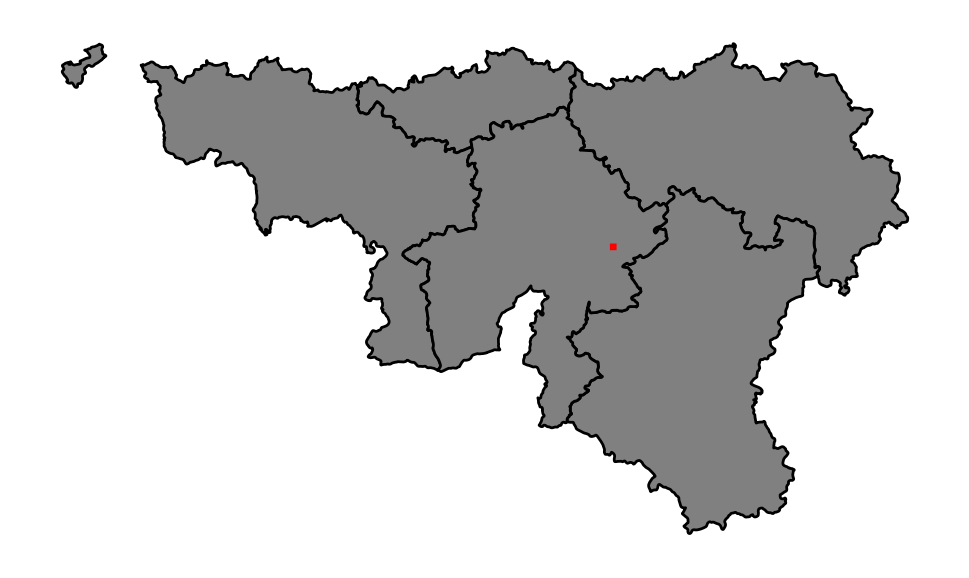

In [6]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

belgium = gpd.read_file("data/belgian_provinces.zip!provinces_L08.shp")
wallonia = belgium[belgium["provISO"].str.startswith("W")]

basemap = wallonia.plot(color="grey", edgecolor="black")
fig = maille.to_crs(wallonia.crs).plot(ax=basemap, color="red")
fig.set_axis_off()

Nous savons maintenant que nous travaillons sur une maille de la province de Namur.

Il nous faut à présent extraire les données de la carte d'occupation du sol (en format raster) pour cette maille.
Pour cela, nous allons travailler avec la carte d'occupation du sol de 2019 en renseignant son chemin d'accès à la variable `OCS_RASTER_FP`. Cette carte d'occupation du sol est dérivée des prédictions d'un modèle deep learning entrainé de manière supervisée sur les données de 2018 et 2020 en utilisant comme réalité-terrain la carte d'occupation du sol de 2018 (i.e.: __WAL_OCS__2018__).

Pour ouvrir le fichier raster, nous allons utiliser la librairie `rasterio`. Et pour lire les données relatives à la maille sélectionnée, nous utiliserons la fonction `mask` implémentée dans cette librairie. Nous prenons garde aussi à maintenir les métadonnées en phase avec la zone de travail.

In [ ]:
OCS_RASTER_FP = "data/WAL_OCS_IA__2019.tif"  # chemin relatif vers le raster WAL_OCS

with rio.open(OCS_RASTER_FP) as r:
    data, affine = mask(
        r,
        maille.to_crs(r.crs).geometry,
        crop=True,
    )
    meta = r.meta
    meta["transform"] = affine
    meta["height"], meta["width"] = data.shape[1:]

Nous pouvons également visualiser la carte d'occupation du sol de 2019 pour cette _maille_.

Les chemins de fer sont représentés dans la nuance de gris la plus foncée. Pour la _maille_ `ORTHO_2018__00530103`, ceux-ci sont visibles dans le bas de la _maille_.

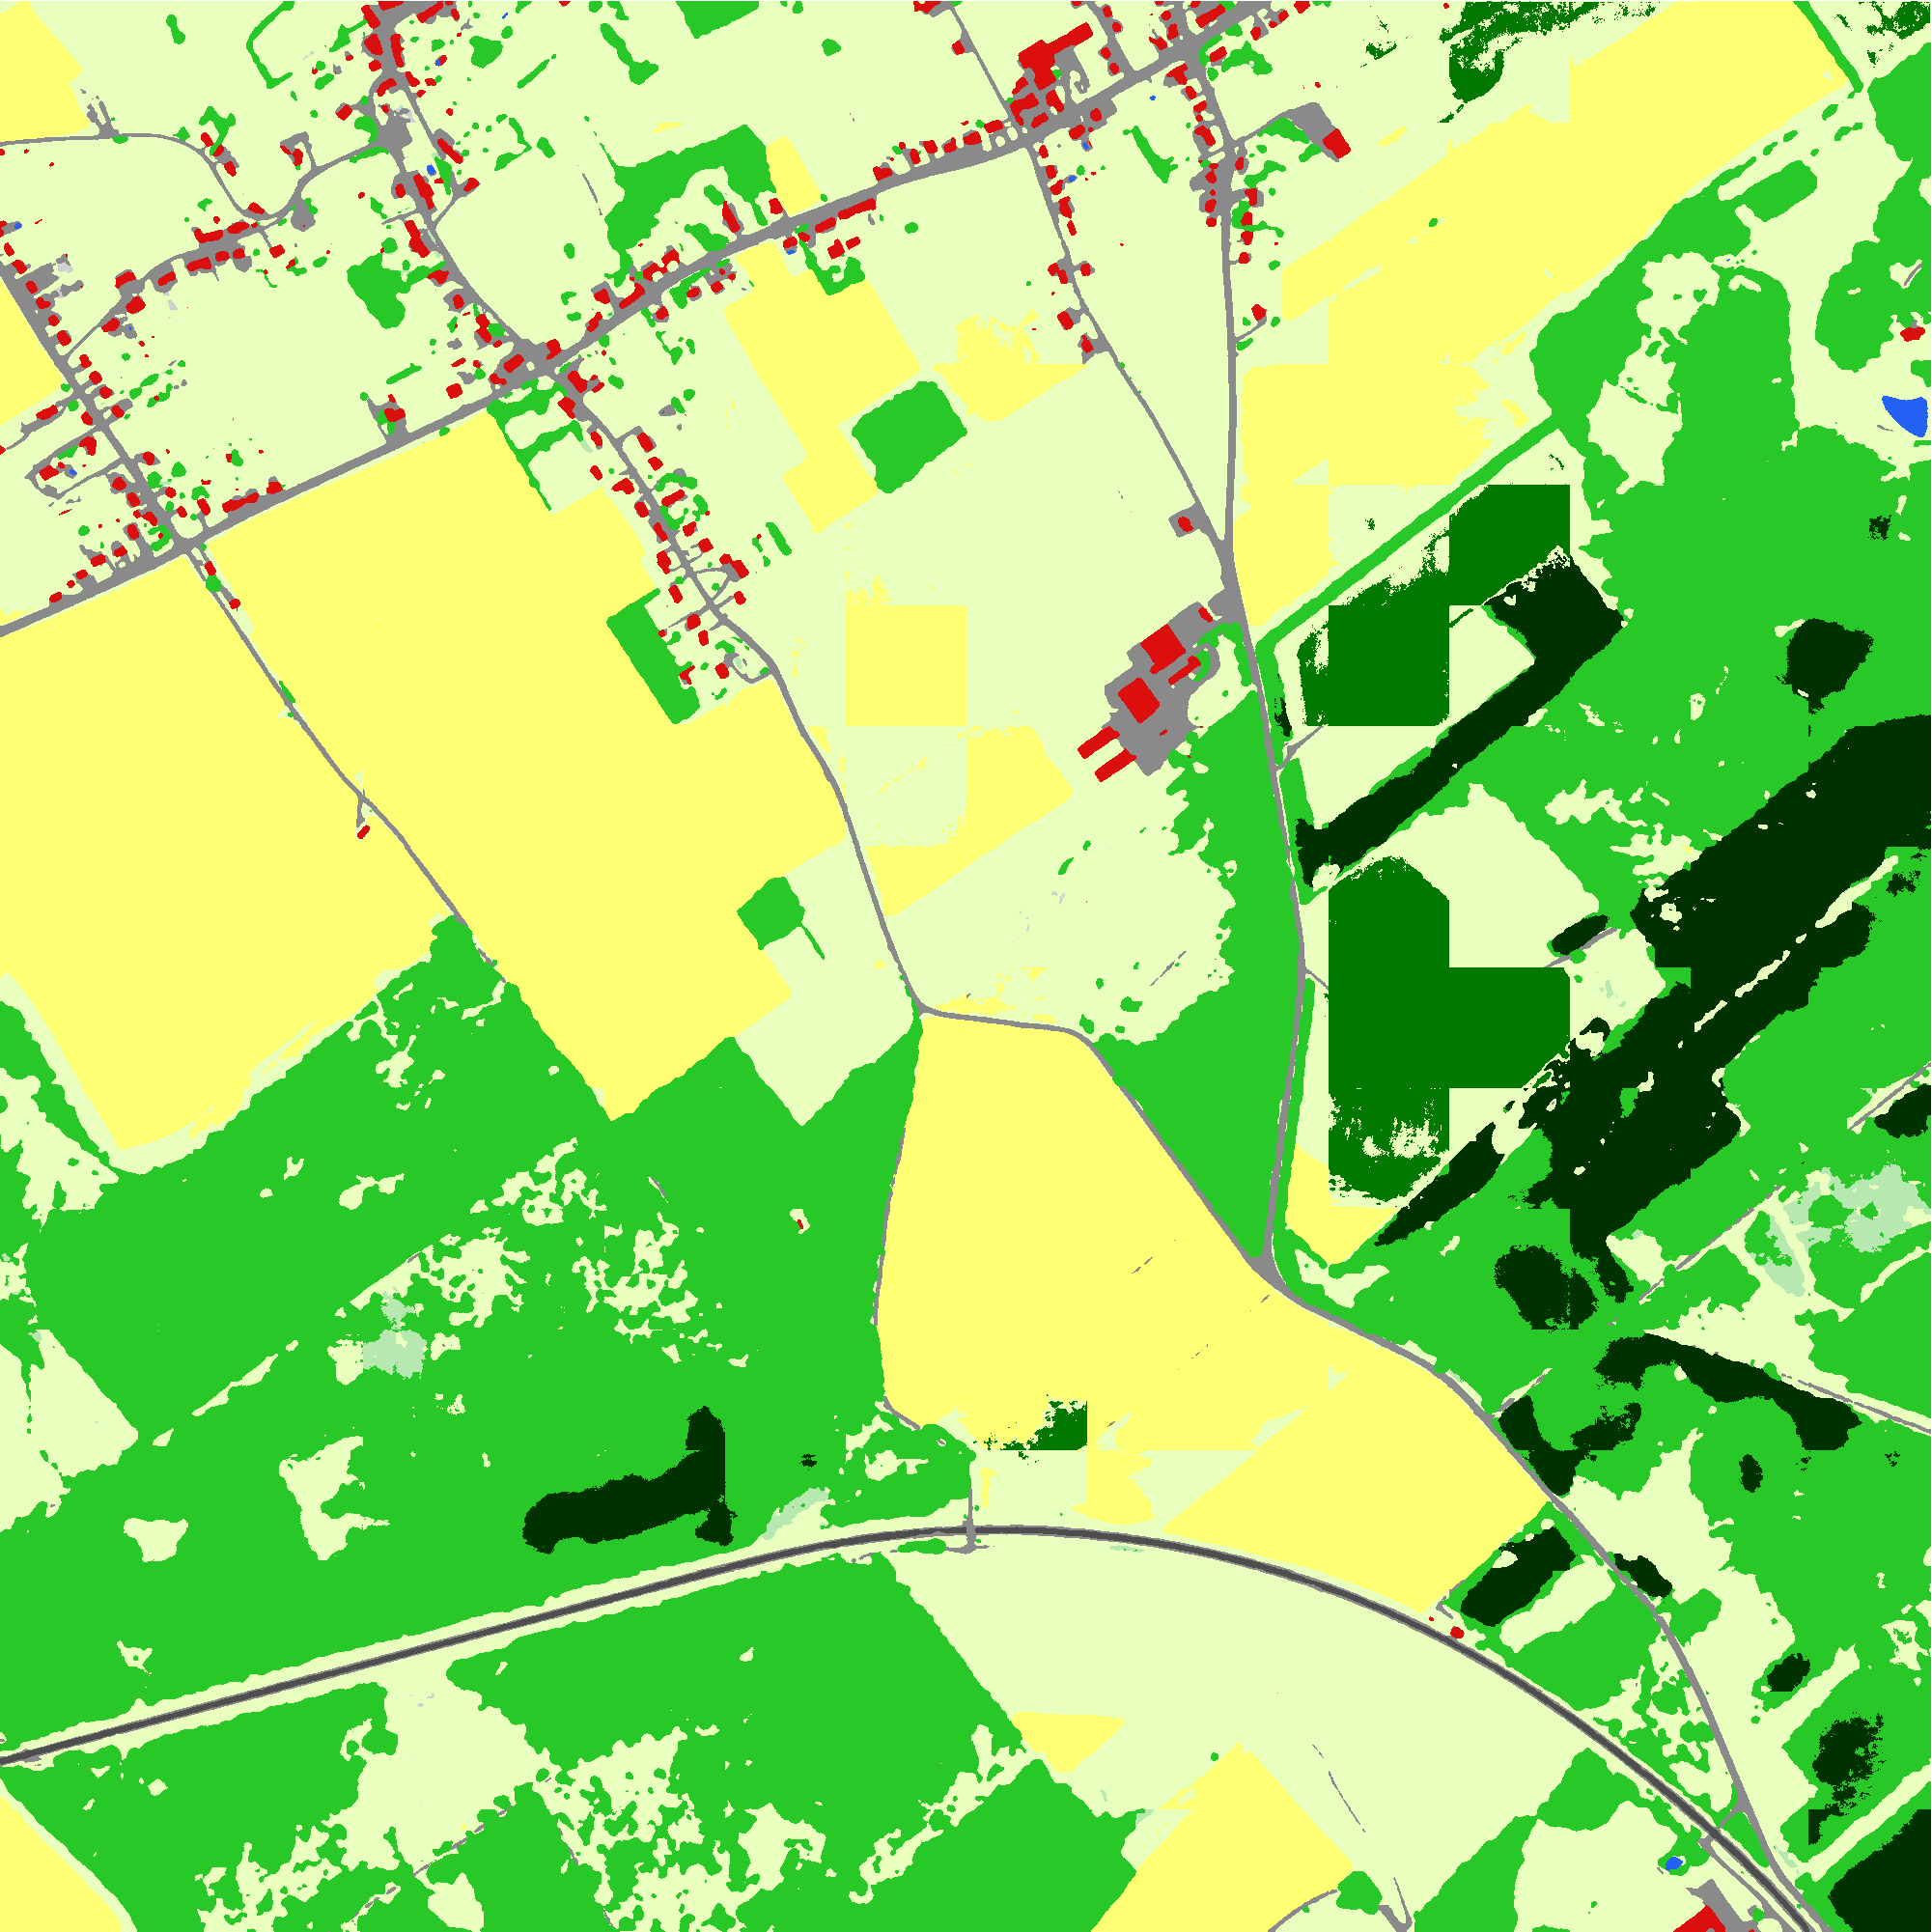

In [7]:
raster2img(data)

#### Vectorisation de la carte d'occupation du sol

Cette étape peut se faire à l'aide de la librairie `rasterio` et de sa fonction `features.shapes`.<br>
Chaque zone homogène du raster est convertie en polygone et la valeur associée à cette zone extraite. Le tout est sauvé dans une `Feature` et l'ensemble de ces `Feature`s est stocké dans un `GeoDataFrame`.

_Note: Le paramètre `connectivity` propose deux options (4 ou 8) permettant de décider si les pixels de la même classe ne se touchant qu'en diagonale doivent faire partie du même polygone. L'option 4 ne considère comme voisins que les pixels du haut, bas, gauche, et droite d'un autre pixel. L'option 8 inclut les 4 autres positions découlant des deux diagonales._

In [8]:
features = []
for polygon, value in shapes(data, transform=affine, connectivity=4):
    features.append(Feature(geometry=polygon, properties={"label": int(value)}))
vect_gdf = gpd.GeoDataFrame.from_features(features, crs=meta["crs"])
# vect_gdf.to_file("data/rail_vectorisation.shp")  # Sauvegarde des données dans un shp
vect_gdf.head(5)

,geometry,label
0,"POLYGON ((706957.370 608007.387, 706957.370 60...",7
1,"POLYGON ((707201.367 608007.387, 707201.367 60...",1
2,"POLYGON ((707283.367 608007.387, 707283.367 60...",7
3,"POLYGON ((707551.364 608007.387, 707551.364 60...",7
4,"POLYGON ((707562.364 608007.387, 707562.364 60...",7


#### Filtration des classes désirées

Nous souhaitons maintenant filtrer parmi les polygones obtenus appartenant aux chemins de fer et ceux appartenant aux forêts (avec une distinction entre les arbres et arbustes).<br>
Cette étape fait appel à des connaissances dans la librairie `pandas`.<br>
Dans chaque situation, un masque est initialement créé pour déterminer les `index` qui répondent aux critères du filtre. Ensuite, ce masque est utilisé pour filtrer les lignes du `GeoDataFrame`.

In [9]:
rail_gdf = vect_gdf[vect_gdf["label"] == 3].copy()
arbres_grand_gdf = vect_gdf[vect_gdf["label"].isin([8, 9])].copy()
arbres_petit_gdf = vect_gdf[vect_gdf["label"].isin([80, 90])].copy()

### Dérivation des zones d'influence des arbres

Pour déterminer la zone d'influence des arbres (i.e. les zones qui pourraient être impactées par la chute d'un arbre), une approche naïve pourrait être de simplement dilater chaque polygone représentant une forêt. Cette dilatation peut se faire en fonction de la taille moyenne des arbres. Prenons pour hypothèse que la taille moyenne des arbres dans les classes 8 et 9 est de 10m et de 3m pour ceux des classes 80 et 90.

L'exemple suivant montre l'effet d'une dilatation sur un autre jeu de données:

<AxesSubplot:>

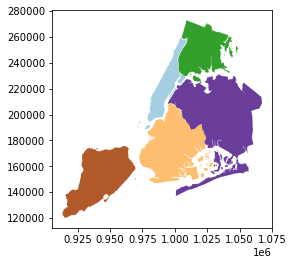

In [7]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
boros.set_index('BoroCode', inplace=True)
boros.sort_index(inplace=True)
boros.plot(cmap='Paired')

<AxesSubplot:>

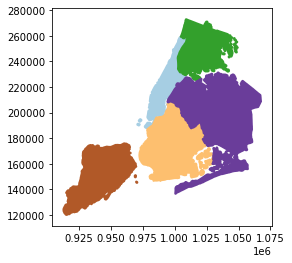

In [11]:
boros.buffer(1000).plot(cmap='Paired')

Appliquons maintenant cette approche `buffer` à nos polygones de forêt:

_Note: L'unité de la valeur renseignée à la fonction `buffer` dépend du système de référence du jeu de données. Ici, puisque nous travaillons avec du Lambert belge 2008, l'unité est le mètre et l'on peut donc directement utiliser les valeurs 10 et 3._

In [13]:
DILATATION_ARBRES = 10
DILATATION_ARBUSTES = 3

arbres_grand_gdf.geometry = arbres_grand_gdf.buffer(DILATATION_ARBRES)
arbres_petit_gdf.geometry = arbres_petit_gdf.buffer(DILATATION_ARBUSTES)

### Détermination des intersections

Les différentes zones d'influence sont comparées au réseau ferrovaire pour trouver les intersections. Ensuite, l'ensemble de ces zones sont réunies dans le même `GeoDataFrame`.

In [14]:
rail_danger_gdf_1 = gpd.overlay(rail_gdf, arbres_grand_gdf, how="intersection")
rail_danger_gdf_2 = gpd.overlay(rail_gdf, arbres_petit_gdf, how="intersection")
rail_danger_gdf = gpd.overlay(rail_danger_gdf_1, rail_danger_gdf_2, how="union")

### Visualisation des résultats

Pour visualiser les zones de danger sur la carte d'occupation du sol de la maille, `rasterio` nous propose d'utiliser la fonction `features.rasterize` pour forcer une donnée vectorielle sur un raster (i.e. `rasterization`). Nous assignons un nouveau label aux pixels de cette zone ainsi qu'une nouvelle couleur:

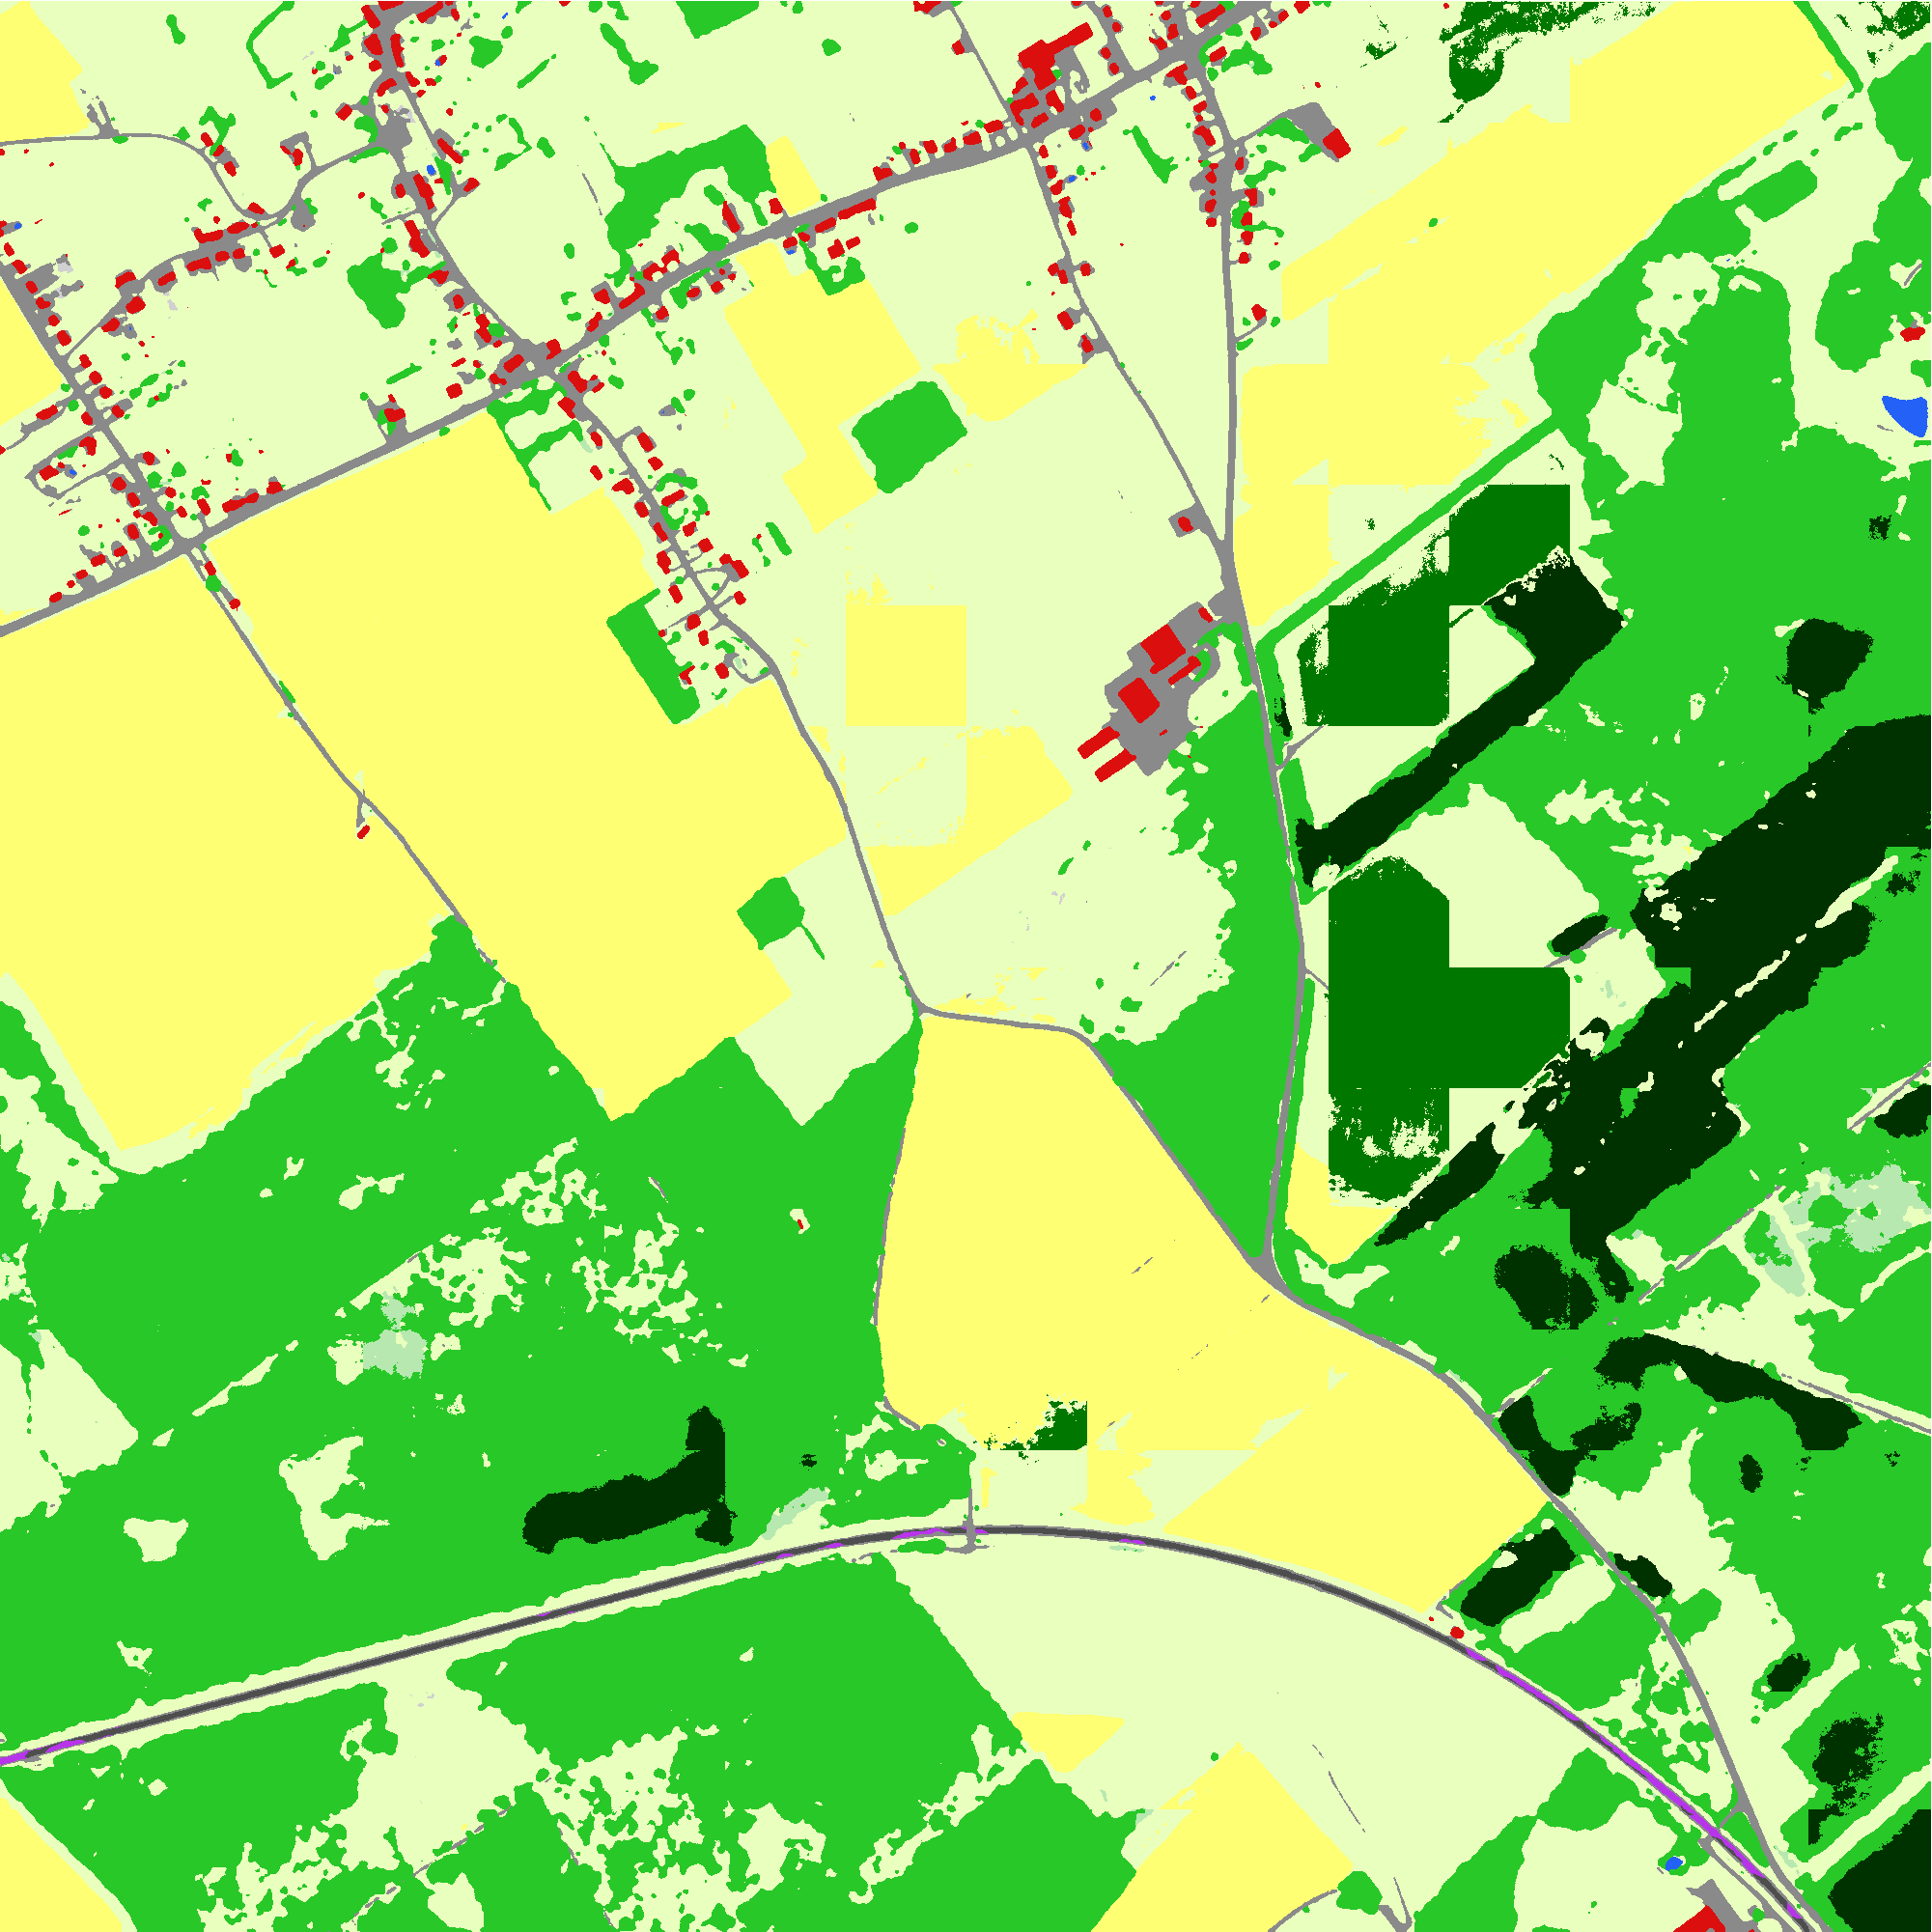

In [15]:
ZONE_DANGER_LABEL = 254
ZONE_DANGER_RGB = (183, 52, 235)  # Violet


data = rasterize(
    rail_danger_gdf.geometry,
    out=data,
    default_value=ZONE_DANGER_LABEL,
    transform=affine,
)

new_cmap = deepcopy(OCS_CMAP)
new_cmap[ZONE_DANGER_LABEL] = ZONE_DANGER_RGB
raster2img(data, new_cmap)